In [84]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

In [62]:
indice_weight = pd.read_excel('data/Insurances.xlsx', sheet_name='raw_weight', skiprows=[1], index_col=0, parse_dates=True)
indice_weight.drop(columns=indice_weight.columns[0], inplace=True)
indice_weight.index.name = 'Date'
indice_weight = indice_weight.T
indice_weight.index = pd.to_datetime(indice_weight.index, format='%m/%d/%Y')
indice_weight = indice_weight / 100
indice_weight.replace(0, np.nan, inplace=True)
indice_weight.head()

Date,BALN SW Equity,GENN SW Equity,HELN SW Equity,NATN SW Equity,CHRN SW Equity,SLHN SW Equity,RUKN VX Equity,VAHN SW Equity,ZURN SW Equity,SREN SW Equity
2005-12-30,0.0492,0.0022,0.0144,0.0053,0.0232,0.0784,0.3588,0.0015,0.4670,NaN
2006-01-31,0.0520,0.0024,0.0151,0.0055,0.0225,0.0771,0.3555,0.0015,0.4683,NaN
2006-02-28,0.0502,0.0023,0.0144,0.0053,0.0218,0.0897,0.3282,0.0014,0.4868,NaN
2006-03-31,0.0557,0.0027,0.0143,0.0058,0.0243,0.0999,0.3179,0.0015,0.4778,NaN
2006-04-28,0.0569,0.0027,0.0163,0.0057,0.0237,0.1048,0.3165,0.0016,0.4718,NaN


In [64]:
prices = pd.read_excel('data/Insurances.xlsx', sheet_name='performance', skiprows=[0,1,2,4,5,6], index_col=0)
daily_returns = prices.pct_change().fillna(0)
daily_returns.head()

,BALN SW Equity,GENN SW Equity,HELN SW Equity,NATN SW Equity,CHRN SW Equity,SLHN SW Equity,RUKN VX Equity,VAHN SW Equity,ZURN SW Equity,SREN SW Equity
2006-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2006-01-05,-0.011134,0.026250,0.003563,0.000000,-0.016700,0.000826,-0.011208,0.007198,-0.014456,-0.011109
2006-01-06,-0.007677,0.005694,-0.001744,0.000000,0.003397,0.001651,0.009790,0.007038,-0.002590,0.009725
2006-01-09,0.009799,0.019772,-0.012480,-0.003094,-0.020311,0.004115,0.000510,0.021183,-0.011242,0.000498
2006-01-10,0.005873,0.002762,-0.021673,0.003104,-0.006220,-0.024179,-0.015798,0.020006,-0.022752,-0.015768


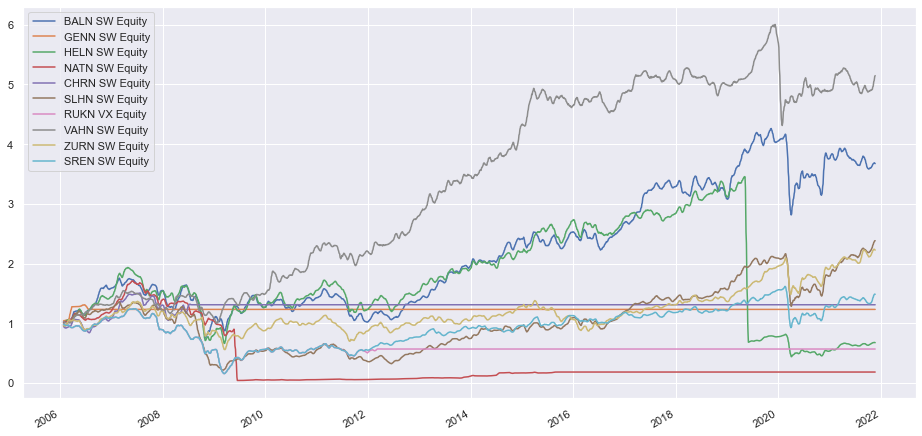

In [85]:
fig, ax = plt.subplots(figsize=(16,8))

(daily_returns + 1).cumprod().rolling(15).mean().plot(ax=ax)
plt.show()

In [86]:
mmonthly_returns = daily_returns.shift(1).resample('M').agg(lambda x: (x + 1).prod() - 1)
max_ret = np.zeros_like(mmonthly_returns.values)
max_ret[np.arange(len(max_ret)), mmonthly_returns.values.argmax(1)] = 1
best_pred = pd.DataFrame(max_ret, columns=mmonthly_returns.columns, index=mmonthly_returns.index).astype(int).shift(-1)
best_pred.head()

,BALN SW Equity,GENN SW Equity,HELN SW Equity,NATN SW Equity,CHRN SW Equity,SLHN SW Equity,RUKN VX Equity,VAHN SW Equity,ZURN SW Equity,SREN SW Equity
2006-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2006-02-28,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-03-31,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2006-05-31,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


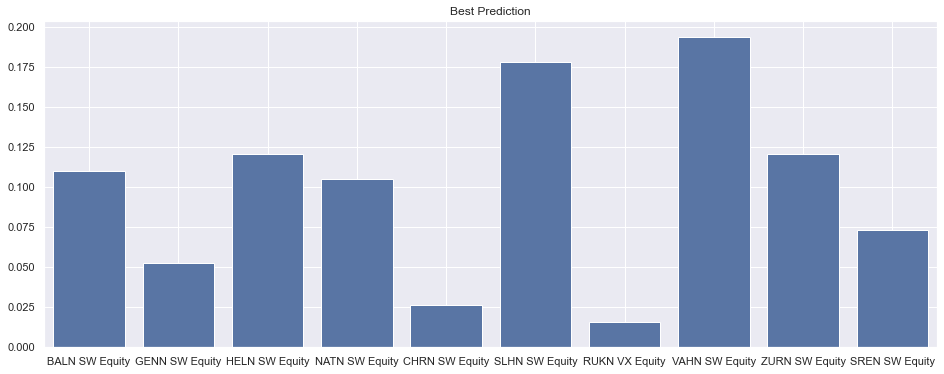

In [96]:
df_results = pd.DataFrame()

df_results = pd.concat([df_results, (best_pred.sum(axis=0) / len(best_pred)).rename('Best_prediction')], axis=1)
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='index', var_name='strategie', value_name='frequence')

fig, ax = plt.subplots(figsize=(16,6))
sns.barplot(ax=ax, data=df_results, x='index', y='frequence', hue='strategie', zorder=2)
ax.get_legend().remove()
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.grid(b=True)
plt.title('Best Prediction')
plt.show()

In [108]:
all_ratios = pd.read_excel('data/ratio_data.xlsx', sheet_name=None, skiprows=[0,1,2,4,5], parse_dates=True, index_col=0)
all_ratios['comb']
df_X = pd.concat(all_ratios, axis=1)
df_X = df_X.swaplevel(0, 1, 1).sort_index(axis=1).fillna(method='ffill')
df_X.head(10)

BALN SW Equity                                                 \
           Cfgrwth_to_INCgrwth  comb    cost incre_oper_marg roc_wacc   vol30   
2006-01-31                 NaN   NaN     NaN             NaN      NaN  16.617   
2006-02-28                 NaN   NaN     NaN             NaN      NaN  15.884   
2006-03-31                 NaN   NaN     NaN             NaN      NaN  31.309   
2006-04-28                 NaN   NaN     NaN             NaN      NaN  26.176   
2006-05-31                 NaN   NaN     NaN             NaN      NaN  27.311   
2006-06-30              5.1602  94.2  27.278        463.8219   0.5543  37.717   
2006-07-31              5.1602  94.2  27.278        463.8219   0.5543  24.633   
2006-08-31              5.1602  94.2  27.278        463.8219   0.5543  15.208   
2006-09-29              5.1602  94.2  27.278        463.8219   0.5543  23.961   
2006-10-31              5.1602  94.2  27.278        463.8219   0.5543  26.711   

                CHRN SW Equity                                          \
           Cfgrwth_to_INCgrwth      comb cost incre_oper_marg roc_wacc   
2006-01-31                 NaN       NaN  NaN             NaN      NaN   
2006-02-28                 NaN       NaN  NaN             NaN      NaN   
2006-03-31                 NaN       NaN  NaN             NaN  -0.4954   
2006-04-28                 NaN       NaN  NaN             NaN  -0.4954   
2006-05-31                 NaN       NaN  NaN             NaN  -0.4954   
2006-06-30             -0.4743  106.8108  NaN             NaN  -0.4658   
2006-07-31             -0.4743  106.8108  NaN             NaN  -0.4658   
2006-08-31             -0.4743  106.8108  NaN             NaN  -0.4658   
2006-09-29             -0.4743  106.8108  NaN             NaN  -0.4658   
2006-10-31             -0.4743  106.8108  NaN             NaN  -0.4658   

                        GENN SW Equity                                     \
             vol30 Cfgrwth_to_INCgrwth comb cost incre_oper_marg roc_wacc   
2006-01-31  27.432                 NaN  NaN  NaN             NaN      NaN   
2006-02-28  19.748                 NaN  NaN  NaN             NaN      NaN   
2006-03-31  32.073                 NaN  NaN  NaN             NaN      NaN   
2006-04-28  22.954                 NaN  NaN  NaN             NaN      NaN   
2006-05-31  41.735                 NaN  NaN  NaN             NaN      NaN   
2006-06-30  59.687                 NaN  NaN  NaN             NaN      NaN   
2006-07-31  33.924                 NaN  NaN  NaN             NaN      NaN   
2006-08-31  20.547                 NaN  NaN  NaN             NaN      NaN   
2006-09-29  22.450                 NaN  NaN  NaN             NaN      NaN   
2006-10-31  20.682                 NaN  NaN  NaN             NaN      NaN   

                        HELN SW Equity                                 \
             vol30 Cfgrwth_to_INCgrwth  comb     cost incre_oper_marg   
2006-01-31  26.095                 NaN   NaN      NaN             NaN   
2006-02-28  27.792                 NaN   NaN      NaN             NaN   
2006-03-31  36.368                 NaN   NaN      NaN             NaN   
2006-04-28   3.429                 NaN   NaN      NaN             NaN   
2006-05-31   5.512                 NaN   NaN      NaN             NaN   
2006-06-30  18.927             -0.9894  95.6  30.9017             NaN   
2006-07-31  30.812             -0.9894  95.6  30.9017             NaN   
2006-08-31  30.812             -0.9894  95.6  30.9017             NaN   
2006-09-29  30.812             -0.9894  95.6  30.9017             NaN   
2006-10-31  30.812             -0.9894  95.6  30.9017             NaN   

                                 NATN SW Equity                     \
           roc_wacc   vol30 Cfgrwth_to_INCgrwth      comb     cost   
2006-01-31      NaN  25.457                 NaN       NaN      NaN   
2006-02-28      NaN  16.703                 NaN       NaN      NaN   
2006-03-31      NaN  21.829                 NaN       NaN      NaN   
20

In [109]:
def strategie(df_input_all, best_pred, rebalance_freq, model_name='MLP', nb_epochs=50, nb_epochs_first=200, input_period=8, month_test_period=5, training_window=5, batch_size=1, verbose=0, threshold=0.4, eta=1e-3):
    
    first_end_date = '2011-01-31'
    num_tickers = len(df_input_all.columns.get_level_values(0).unique())
    num_features = len(df_input_all.columns.get_level_values(1).unique())
    
    prob_output = []
    pred_output = []
    
    all_end_dates = best_pred.loc[first_end_date:].asfreq('6M').index

    for i, end_date in enumerate(tqdm(all_end_dates)):

        start_date = end_date - relativedelta(years=training_window)
        
        # The first date input must before the first date output
        if rebalance_freq =='M':
            # Make sur the input period start the 1st of the month
            start_date_input = (start_date - relativedelta(months=input_period)).replace(day=1) 
        else:
            start_date_input = start_date - relativedelta(days=input_period)
            # Make sur the input period start a monday
            start_date_input = start_date_input - relativedelta(days=(start_date_input.weekday()))

        df_input = df_input_all.loc[start_date_input:end_date]
        df_output = best_pred.loc[start_date:end_date]

        X = []
        for idx in df_output.index:
            # If we rebalance monthly, the input data will be weekly data
            if rebalance_freq == 'M':
                df_input_period = df_input.loc[:idx].asfreq('W', method='ffill').iloc[-input_period:]
            # If we rebalance weekly, the input data will be daily data
            else:
                df_input_period = df_input.loc[:idx].iloc[-input_period:]
                
            X_period = df_input_period.values.reshape(input_period, num_tickers, num_features)
            X.append(X_period)

        X = np.array(X)
        y = df_output.values
        
        # Find the first prediction date
        if i == 0:
            if rebalance_freq == 'M':
                first_start_date_test = end_date - relativedelta(months=5)
            else:
                first_start_date_test = end_date - relativedelta(weeks=25)
        
        if rebalance_freq == 'M':
            start_date_test = (end_date - relativedelta(months=5))
            # Make sur the first test date is the end of the month
            year_test, month_test = start_date_test.year, start_date_test.month
            start_date_test = start_date_test.replace(day=calendar.monthrange(year_test, month_test)[1])
            split_index = df_output.index.get_loc(start_date_test)    
        else:
            start_date_test = end_date - relativedelta(weeks=25)
            # Make sur the first test date is a friday
            delta_days = 4 - start_date_test.weekday()
            if delta_days < 0:
                delta_days += 7
            start_date_test = start_date_test + relativedelta(days=delta_days)
            split_index = df_output.index.get_loc(start_date_test)  
        
        # Create train and test set
        X_train, y_train = X[:split_index], y[:split_index]
        X_test, y_test = X[split_index:], y[split_index:]
        
        # Transform Numpy arrays to Torch tensors
        X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()
        
        # Standardize data within each feature 
        train_mean = X_train.mean(dim=[0, 1, 2], keepdim=True)
        train_std = X_train.std(dim=[0, 1, 2], keepdim=True)
        X_train = X_train.sub_(train_mean).div_(train_std)
    
        test_mean = X_test.mean(dim=[0, 1, 2], keepdim=True)
        test_std = X_test.std(dim=[0, 1, 2], keepdim=True)
        X_test = X_test.sub_(test_mean).div_(test_std)
        
        # Allocate the tensors to the GPU, if there is one
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        X_train = X_train.to(device)
        X_test = X_test.to(device)
        y_train = y_train.to(device)
        y_test = y_test.to(device)
        
        # Initialize ML models only at first iteration
        dim1, dim2, dim3 = X_train.size(1), X_train.size(2), X_train.size(3)
        if i == 0:
            if model_name == 'MLP':
                model = MLP(dim1, dim2, dim3)
            elif model_name == 'ConvNet':
                model = ConvNet(dim1, dim2, dim3)
            elif model_name == 'LSTM':
                model = LSTM(input_size=num_tickers * num_features, output_size=num_tickers)
        model.to(device)
        
        # More epochs needed for the first iteration 
        if i == 0:
            nb_epochs_all = nb_epochs_first
        else:
            nb_epochs_all = nb_epochs
        # Train the model
        train(model, X_train, y_train, nb_epochs_all, X_test, y_test, i, eta=eta, batch_size=batch_size, verbose=verbose)

        # Get predictions
        prob, pred = test(model, X_test, y_test, threshold=threshold)
        pred_output.append(pred)
        prob_output.append(prob)

    pred_output = np.array(pred_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
    df_pred = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=pred_output, columns=best_pred.columns)
    prob_output = np.array(prob_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
    df_prob = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=prob_output, columns=best_pred.columns)
    
    return df_pred, df_prob

In [ ]:
df_input_all = df_X
input_period = 6

first_end_date = '2011-01-31'
num_tickers = len(df_input_all.columns.get_level_values(0).unique())
num_features = len(df_input_all.columns.get_level_values(1).unique())

prob_output = []
pred_output = []

all_end_dates = best_pred.loc[first_end_date:].asfreq('6M').index

for i, end_date in enumerate(tqdm(all_end_dates)):

    start_date = end_date - relativedelta(years=training_window)

    start_date_input = (start_date - relativedelta(months=input_period)).replace(day=1) 

    df_input = df_input_all.loc[start_date_input:end_date]
    df_output = best_pred.loc[start_date:end_date]

    X = []
    for idx in df_output.index:
        # If we rebalance monthly, the input data will be weekly data
        if rebalance_freq == 'M':
            df_input_period = df_input.loc[:idx].asfreq('W', method='ffill').iloc[-input_period:]
        # If we rebalance weekly, the input data will be daily data
        else:
            df_input_period = df_input.loc[:idx].iloc[-input_period:]

        X_period = df_input_period.values.reshape(input_period, num_tickers, num_features)
        X.append(X_period)

    X = np.array(X)
    y = df_output.values

    # Find the first prediction date
    if i == 0:
        if rebalance_freq == 'M':
            first_start_date_test = end_date - relativedelta(months=5)
        else:
            first_start_date_test = end_date - relativedelta(weeks=25)

    if rebalance_freq == 'M':
        start_date_test = (end_date - relativedelta(months=5))
        # Make sur the first test date is the end of the month
        year_test, month_test = start_date_test.year, start_date_test.month
        start_date_test = start_date_test.replace(day=calendar.monthrange(year_test, month_test)[1])
        split_index = df_output.index.get_loc(start_date_test)    
    else:
        start_date_test = end_date - relativedelta(weeks=25)
        # Make sur the first test date is a friday
        delta_days = 4 - start_date_test.weekday()
        if delta_days < 0:
            delta_days += 7
        start_date_test = start_date_test + relativedelta(days=delta_days)
        split_index = df_output.index.get_loc(start_date_test)  

    # Create train and test set
    X_train, y_train = X[:split_index], y[:split_index]
    X_test, y_test = X[split_index:], y[split_index:]

    # Transform Numpy arrays to Torch tensors
    X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

    # Standardize data within each feature 
    train_mean = X_train.mean(dim=[0, 1, 2], keepdim=True)
    train_std = X_train.std(dim=[0, 1, 2], keepdim=True)
    X_train = X_train.sub_(train_mean).div_(train_std)

    test_mean = X_test.mean(dim=[0, 1, 2], keepdim=True)
    test_std = X_test.std(dim=[0, 1, 2], keepdim=True)
    X_test = X_test.sub_(test_mean).div_(test_std)

    # Allocate the tensors to the GPU, if there is one
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train = X_train.to(device)
    X_test = X_test.to(device)
    y_train = y_train.to(device)
    y_test = y_test.to(device)

    # Initialize ML models only at first iteration
    dim1, dim2, dim3 = X_train.size(1), X_train.size(2), X_train.size(3)
    if i == 0:
        if model_name == 'MLP':
            model = MLP(dim1, dim2, dim3)
        elif model_name == 'ConvNet':
            model = ConvNet(dim1, dim2, dim3)
        elif model_name == 'LSTM':
            model = LSTM(input_size=num_tickers * num_features, output_size=num_tickers)
    model.to(device)

    # More epochs needed for the first iteration 
    if i == 0:
        nb_epochs_all = nb_epochs_first
    else:
        nb_epochs_all = nb_epochs
    # Train the model
    train(model, X_train, y_train, nb_epochs_all, X_test, y_test, i, eta=eta, batch_size=batch_size, verbose=verbose)

    # Get predictions
    prob, pred = test(model, X_test, y_test, threshold=threshold)
    pred_output.append(pred)
    prob_output.append(prob)

pred_output = np.array(pred_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
df_pred = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=pred_output, columns=best_pred.columns)
prob_output = np.array(prob_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
df_prob = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=prob_output, columns=best_pred.columns)

return df_pred, df_prob

def clean_ratio(df_ratio):
    
    df = df_ratio.copy()
    for index, row in df.iterrows():
        for ticker, value in row.items():   
            if pd.isna(indice_weight.at[index, ticker]):
                row.at[ticker] = np.nan
                
    return df